In [128]:
import os
import sys
import pickle
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import torch
from sklearn.preprocessing import LabelEncoder
from torch.optim import optimizer
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from torch.nn import CrossEntropyLoss,BCEWithLogitsLoss
from tqdm import tqdm_notebook, trange
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM, BertForSequenceClassification
from pytorch_pretrained_bert.optimization import BertAdam, WarmupLinearSchedule
from sklearn.metrics import precision_recall_curve,classification_report
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
%matplotlib inline

In [129]:
model = torch.load(open("job_fine_tuned_bert.bin", "rb"))
device = torch.device('cuda')  
model = model.to(device)

In [130]:
test_data = pd.read_csv('增广数据集/result2010.csv',index_col = 0)
labelmap = pd.read_excel('train_labels.xlsx')
labelid = []
for i in range(len(test_data)):
    thislabel = test_data.loc[i,'label']
    for j in range(140):
        if labelmap.loc[j,'label']==thislabel:
            labelid.append(labelmap.loc[j,'label_id'])
            break
test_data['label_id'] = labelid
# save a dataframe copy of tensorData
result = test_data
test_data.head()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15111 entries, 0 to 15110
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      15111 non-null  object
 1   label     15111 non-null  object
 2   match     15111 non-null  object
 3   label_id  15111 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.1+ MB


In [131]:
# 数据处理类
class DataPrecessForSingleSentence(object):
    """
    对文本进行处理
    """

    def __init__(self, bert_tokenizer, max_workers=10):
        """
        bert_tokenizer :分词器
        dataset        :包含列名为'text'与'label'的pandas dataframe
        """
        self.bert_tokenizer = bert_tokenizer
        # 创建多线程池
        self.pool = ThreadPoolExecutor(max_workers=max_workers)
        # 获取文本与标签

    def get_input(self, dataset, max_seq_len=50):
        """
        通过多线程（因为notebook中多进程使用存在一些问题）的方式对输入文本进行分词、ID化、截断、填充等流程得到最终的可用于模型输入的序列。
        
        入参:
            dataset     : pandas的dataframe格式，包含两列，第一列为文本，第二列为标签。标签取值为{0,1}，其中0表示负样本，1代表正样本。
            max_seq_len : 目标序列长度，该值需要预先对文本长度进行分别得到，可以设置为小于等于512（BERT的最长文本序列长度为512）的整数。
        
        出参:
            seq         : 在入参seq的头尾分别拼接了'CLS'与'SEP'符号，如果长度仍小于max_seq_len，则使用0在尾部进行了填充。
            seq_mask    : 只包含0、1且长度等于seq的序列，用于表征seq中的符号是否是有意义的，如果seq序列对应位上为填充符号，
                          那么取值为1，否则为0。
            seq_segment : shape等于seq，因为是单句，所以取值都为0。
            labels      : 标签取值为{0,1}，其中0表示负样本，1代表正样本。   
        """
        sentences = dataset.iloc[:, 0].tolist()
        labels = dataset.iloc[:, 3].tolist()
        # 切词
        tokens_seq = list(
            self.pool.map(self.bert_tokenizer.tokenize, sentences))
        # 获取定长序列及其mask
        result = list(
            self.pool.map(self.trunate_and_pad, tokens_seq,
                          [max_seq_len] * len(tokens_seq)))
        seqs = [i[0] for i in result]
        seq_masks = [i[1] for i in result]
        seq_segments = [i[2] for i in result]
        return seqs, seq_masks, seq_segments, labels

    def trunate_and_pad(self, seq, max_seq_len):
        """
        1. 因为本类处理的是单句序列，按照BERT中的序列处理方式，需要在输入序列头尾分别拼接特殊字符'CLS'与'SEP'，
           因此不包含两个特殊字符的序列长度应该小于等于max_seq_len-2，如果序列长度大于该值需要那么进行截断。
        2. 对输入的序列 最终形成['CLS',seq,'SEP']的序列，该序列的长度如果小于max_seq_len，那么使用0进行填充。
        
        入参: 
            seq         : 输入序列，在本处其为单个句子。
            max_seq_len : 拼接'CLS'与'SEP'这两个特殊字符后的序列长度
        
        出参:
            seq         : 在入参seq的头尾分别拼接了'CLS'与'SEP'符号，如果长度仍小于max_seq_len，则使用0在尾部进行了填充。
            seq_mask    : 只包含0、1且长度等于seq的序列，用于表征seq中的符号是否是有意义的，如果seq序列对应位上为填充符号，
                          那么取值为1，否则为0。
            seq_segment : shape等于seq，因为是单句，所以取值都为0。
           
        """
        # 对超长序列进行截断
        if len(seq) > (max_seq_len - 2):
            seq = seq[0:(max_seq_len - 2)]
        # 分别在首尾拼接特殊符号
        seq = ['[CLS]'] + seq + ['[SEP]']
        # ID化
        seq = self.bert_tokenizer.convert_tokens_to_ids(seq)
        # 根据max_seq_len与seq的长度产生填充序列
        padding = [0] * (max_seq_len - len(seq))
        # 创建seq_mask
        seq_mask = [1] * len(seq) + padding
        # 创建seq_segment
        seq_segment = [0] * len(seq) + padding
        # 对seq拼接填充序列
        seq += padding
        assert len(seq) == max_seq_len
        assert len(seq_mask) == max_seq_len
        assert len(seq_segment) == max_seq_len
        return seq, seq_mask, seq_segment

In [132]:
# 分词工具
bert_tokenizer = BertTokenizer.from_pretrained('chinese_wwm_ext_pytorch/', do_lower_case=False)
# 类初始化
processor = DataPrecessForSingleSentence(bert_tokenizer= bert_tokenizer)


test_seqs, test_seq_masks, test_seq_segments, test_labels = processor.get_input(
    dataset=test_data)
test_seqs = torch.tensor(test_seqs, dtype=torch.long)
test_seq_masks = torch.tensor(test_seq_masks, dtype = torch.long)
test_seq_segments = torch.tensor(test_seq_segments, dtype = torch.long)
test_labels = torch.tensor(test_labels, dtype = torch.long)
test_data = TensorDataset(test_seqs, test_seq_masks, test_seq_segments, test_labels)
test_dataloder = DataLoader(dataset= test_data, batch_size = 192)
# 用于存储预测标签与真实标签
true_labels = []
pred_labels = []
pval_labels = []
model.eval()
# 预测
with torch.no_grad():
    for batch_data in tqdm_notebook(test_dataloder, desc = 'TEST'):
        batch_data = tuple(t.to(device) for t in batch_data)
        batch_seqs, batch_seq_masks, batch_seq_segments, batch_labels = batch_data        
        logits = model(
            batch_seqs, batch_seq_masks, batch_seq_segments, labels=None)
        
        #logits = logits.softmax(dim=1).argmax(dim = 1)
        logits = logits.softmax(dim=1)
        num_rows = logits.shape[0]
        for i in range(0,num_rows):
            pval = logits[i][batch_labels[i]]
            pval_labels.append(pval.detach().cpu().numpy())
            #print(pval)
            #print(batch_labels[i])
        #print(pval_labels)
            
        #pred_labels.append(logits.detach().cpu().numpy())
        #true_labels.append(batch_labels.detach().cpu().numpy())

<ipython-input-132-e0cea4e65fb8>:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_data in tqdm_notebook(test_dataloder, desc = 'TEST'):


TEST:   0%|          | 0/79 [00:00<?, ?it/s]

In [133]:
result['pval'] = pval_labels

In [134]:
print('mean:',np.mean(pval_labels),'max:',np.max(pval_labels),'min:',np.min(pval_labels))

mean: 0.017885538 max: 0.6991793 min: 0.00053239457


Text(0, 0.5, 'Pval')

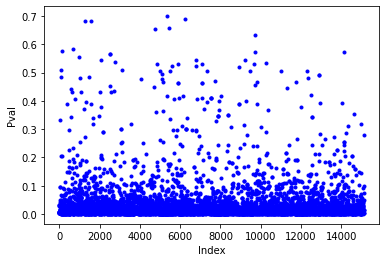

In [135]:
import matplotlib.pyplot as plt

plt.plot(pval_labels,marker = ".",color="blue",linestyle="none")
plt.xlabel("Index")
plt.ylabel("Pval")

In [138]:
#result2 是删除置信度低的预测后的数据
result2 = result.drop(result[result['pval'] < 0.01].index)
result2 = result2.reset_index(drop = True)
result2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4694 entries, 0 to 4693
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      4694 non-null   object
 1   label     4694 non-null   object
 2   match     4694 non-null   object
 3   label_id  4694 non-null   int64 
 4   pval      4694 non-null   object
dtypes: int64(1), object(4)
memory usage: 183.5+ KB


In [139]:
#result3删除了单match对应多label的错误数据
Index = []
for i in range(0,len(result2)):
    j = 1
    flag = 0
    if i+j<len(result2):
        while (result2.iloc[i,2] == result2.iloc[i+j,2]):
            j+=1
            flag = 1
            if i+j >= len(result2):
                break;
        if flag == 1:
            max_p = 0
            max_index = -1
            for k in range(0,j):
                if result2.iloc[i+k,4] <= max_p:
                    Index.append(i+k)
                else:
                    max_p = result2.iloc[i+k,4]
                    if max_index != -1:
                        Index.append(max_index)
                    max_index = i+k
result3 = result2.drop(Index)
result3 = result3.reset_index(drop= True)
result3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4098 entries, 0 to 4097
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      4098 non-null   object
 1   label     4098 non-null   object
 2   match     4098 non-null   object
 3   label_id  4098 non-null   int64 
 4   pval      4098 non-null   object
dtypes: int64(1), object(4)
memory usage: 160.2+ KB


In [140]:
result3.to_excel('清洗后增广数据/2010_afterClean.xlsx')